In [1]:
%matplotlib inline
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lxml import etree

## Чтение данных

In [2]:
train_path = "tasks/"

In [3]:
xmls_paths = list(filter(lambda f: f.endswith(".xml"), os.listdir(train_path)))

In [4]:
%%time

train_data = []

for xml_path in xmls_paths:
    train_xml_path = os.path.join(train_path, xml_path)
    xml_root = etree.parse(train_xml_path)
    suspicious_path = xml_root.getroot().attrib["reference"]
    suspicious_text = open(os.path.join("susp", suspicious_path)).read()
    for feature in xml_root.xpath("feature"):
        train_row = {}
        # Read raw data
        suspicious_offset = int(feature.attrib["this_offset"])
        suspicious_length = int(feature.attrib["this_length"])
        source_offset = int(feature.attrib["source_offset"])
        source_length = int(feature.attrib["source_length"])
        source_path = feature.attrib["source_reference"]
        # Set df values
        train_row["obfuscation"] = feature.attrib["obfuscation"]
        train_row["suspicious_path"] = suspicious_path
        train_row["suspicious_offset"] = suspicious_offset
        train_row["suspicious_length"] = suspicious_length
        train_row["source_path"] = source_path
        train_row["source_offset"] = source_offset
        train_row["source_length"] = source_length
        # Read texts and set values
        source_text = open(os.path.join("src", source_path)).read()
        train_row["suspicious_text"] = suspicious_text[suspicious_offset : suspicious_offset + suspicious_length]
        train_row["source_text"] = source_text[source_offset : source_offset + source_length]
        train_data.append(train_row)

CPU times: user 1.67 s, sys: 88 ms, total: 1.75 s
Wall time: 1.75 s


In [13]:
train_df = pd.DataFrame(train_data)

In [15]:
%time train_df.to_csv("train_texts.csv")

CPU times: user 143 ms, sys: 5 ms, total: 148 ms
Wall time: 148 ms


## Изучение данных

In [5]:
len(train_data)

10885

In [7]:
train_df[["obfuscation", "source_path", "source_text", "suspicious_path", "suspicious_text"]].head(20)

,obfuscation,source_path,source_text,suspicious_path,suspicious_text
0,DEL,3182571.txt,"МОНДРИАН, ПИТ (наст. имя Питер Корнелис) (Mond...",043.txt,Пит Мондриан (наст.имя Питер Корнелис) (1872–1...
1,HPR,3182571.txt,"В 1911 он познакомился с кубистами, и их творч...",043.txt,Вскоре после знакомства с кубистами в 1911 год...
2,HPR,3182571.txt,Вскоре Мондриан отказался в своих картинах от ...,043.txt,Вскоре после знакомства с кубистами в 1911 год...
3,CCT,3182571.txt,В 1912—1916 он строил композиции на основе сво...,043.txt,В 1912—1916 он строил композиции на основе сво...
4,CCT,3182571.txt,"В это время Мондриан, подобно Жоржу Браку и Па...",043.txt,В 1912—1916 он строил композиции на основе сво...
5,CCT,3182571.txt,К 1920 стиль Мондриана полностью сформировался.,043.txt,К 1920 стиль Мондриана полностью сформировался...
6,CCT,3182571.txt,"Используя прямые линии жестких контуров, он де...",043.txt,К 1920 стиль Мондриана полностью сформировался...
7,CCT,3182571.txt,Мондриан еще больше сократил свои художественн...,043.txt,К 1920 стиль Мондриана полностью сформировался...
8,LPR,3182571.txt,Умер Мондриан в Нью-Йорке 1 февраля 1944.,043.txt,Мондриан скончался в Нью-Йорке 1 февраля 1944.
9,CCT,3182571.txt,Его произведения оказали влияние на многих сов...,043.txt,Его произведения оказали влияние на многих сов...


In [10]:
train_df[(train_df["source_path"] == "1320906.txt") & (train_df["suspicious_path"] == "004.txt")]

,obfuscation,source_length,source_offset,source_path,source_text,suspicious_length,suspicious_offset,suspicious_path,suspicious_text
364,DEL,92,4794,1320906.txt,Несмотря на свои величайшие заслуги перед наук...,75,7385,004.txt,"Несмотря на величайшие заслуги перед наукой, Н..."
365,HPR,54,4887,1320906.txt,"О себе он говорил так: «Не знаю, каким я кажус...",59,7541,004.txt,"Он не знал, каким он казался людям, и так и го..."
366,LPR,245,4942,1320906.txt,"Самому же себе я кажусь ребенком, который игра...",235,7601,004.txt,"Самому же себе он казался ребенком, который иг..."
367,ADD,91,5189,1320906.txt,"По описанию тех, кто его знал, Ньютон был мужч...",104,7837,004.txt,"Однако по описанию тех людей, кто его знал, Нь..."
368,HPR,56,5281,1320906.txt,"Согласно традиции того времени, голову покрыва...",35,7942,004.txt,Следуя обычиям тех лет носил парик.
369,HPR,85,5406,1320906.txt,"Погруженный в глубокие размышления, часто не з...",35,7942,004.txt,Следуя обычиям тех лет носил парик.
370,CCT,34,5371,1320906.txt,Ньютон вел уединенный образ жизни.,136,7978,004.txt,Ньютон вел преимущественно уединенный образ жи...
371,CCT,85,5406,1320906.txt,"Погруженный в глубокие размышления, часто не з...",136,7978,004.txt,Ньютон вел преимущественно уединенный образ жи...
372,DEL,170,5492,1320906.txt,"Иногда по утрам, вставая с постели, вдруг заду...",150,8227,004.txt,Иногда по утрам вдруг задумывался и в таком по...
373,ADD,44,5663,1320906.txt,"Увлекшись работой, совершенно забывал о еде.",54,8378,004.txt,"Нередко увлекшись работой, совершенно забывал..."


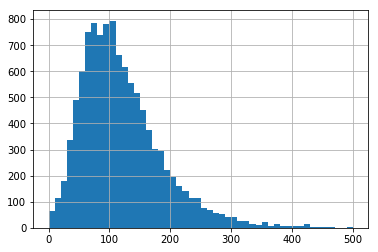

In [8]:
train_df["source_length"].hist(bins=50, range=(0, 500))

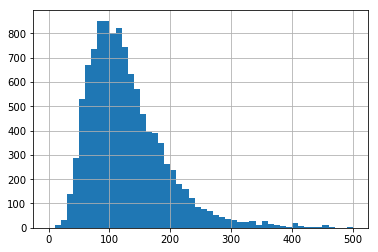

In [9]:
train_df["suspicious_length"].hist(bins=50, range=(0, 500))

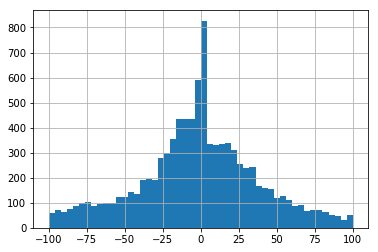

In [10]:
(train_df["source_length"] - train_df["suspicious_length"]).hist(bins=50, range=(-100, 100))

---

In [40]:
train_df[train_df["obfuscation"] == "LPR"]

,obfuscation,source_length,source_offset,source_path,source_text,suspicious_length,suspicious_offset,suspicious_path,suspicious_text
8,LPR,41,3742,3182571.txt,Умер Мондриан в Нью-Йорке 1 февраля 1944.,47,3739,043.txt,Мондриан скончался в Нью-Йорке 1 февраля 1944.
14,LPR,90,1181,4812682.txt,Ее наиболее известные книги — это “Гордость и ...,103,2162,047.txt,Самые известные произведения Джейн Остин — это...
15,LPR,87,1272,4812682.txt,Вирджиния Вульф называла Остин “самой замечате...,94,2266,047.txt,Вирджиния Вульф отзывалась о ней как о “самой ...
30,LPR,136,3057,4812682.txt,Она очень стеснялась своего занятия и писала н...,137,3487,047.txt,Она очень стеснялась своего занятия и писала н...
31,LPR,122,3616,4812682.txt,Джордж Остин поддерживал увлечение дочери и пр...,120,3625,047.txt,Джордж Остин поддерживал увлечение дочери: пыт...
44,LPR,31,4781,4812682.txt,О нем заботилась местная семья.,39,4711,047.txt,Об этом брате заботилась местная семья.
48,LPR,137,5346,4812682.txt,"Согласно некоторым источникам, более ранняя ве...",146,5132,047.txt,"Отдельные источники сообщают, что ранняя верси..."
61,LPR,68,7073,4812682.txt,"Полковник Брэндон, пожилой господин, который н...",63,6308,047.txt,"Полковник Брэндон, пожилой господин, не привле..."
68,LPR,143,7923,4812682.txt,Она отвергает его первое предложение вступить ...,144,6984,047.txt,Главная героиня отвергает его предложение всту...
70,LPR,53,8153,4812682.txt,Книга вышла в трех печатных изданиях при жизни...,59,7221,047.txt,Книгу напечатали в трех печатных изданиях при ...


In [47]:
train_df[train_df["obfuscation"] == "LPR"]

,obfuscation,source_length,source_offset,source_path,source_text,suspicious_length,suspicious_offset,suspicious_path,suspicious_text
8,LPR,41,3742,3182571.txt,Умер Мондриан в Нью-Йорке 1 февраля 1944.,47,3739,043.txt,Мондриан скончался в Нью-Йорке 1 февраля 1944.
14,LPR,90,1181,4812682.txt,Ее наиболее известные книги — это “Гордость и ...,103,2162,047.txt,Самые известные произведения Джейн Остин — это...
15,LPR,87,1272,4812682.txt,Вирджиния Вульф называла Остин “самой замечате...,94,2266,047.txt,Вирджиния Вульф отзывалась о ней как о “самой ...
30,LPR,136,3057,4812682.txt,Она очень стеснялась своего занятия и писала н...,137,3487,047.txt,Она очень стеснялась своего занятия и писала н...
31,LPR,122,3616,4812682.txt,Джордж Остин поддерживал увлечение дочери и пр...,120,3625,047.txt,Джордж Остин поддерживал увлечение дочери: пыт...
44,LPR,31,4781,4812682.txt,О нем заботилась местная семья.,39,4711,047.txt,Об этом брате заботилась местная семья.
48,LPR,137,5346,4812682.txt,"Согласно некоторым источникам, более ранняя ве...",146,5132,047.txt,"Отдельные источники сообщают, что ранняя верси..."
61,LPR,68,7073,4812682.txt,"Полковник Брэндон, пожилой господин, который н...",63,6308,047.txt,"Полковник Брэндон, пожилой господин, не привле..."
68,LPR,143,7923,4812682.txt,Она отвергает его первое предложение вступить ...,144,6984,047.txt,Главная героиня отвергает его предложение всту...
70,LPR,53,8153,4812682.txt,Книга вышла в трех печатных изданиях при жизни...,59,7221,047.txt,Книгу напечатали в трех печатных изданиях при ...


---

**Распределение типов плагиата**

In [43]:
collections.Counter(train_df["obfuscation"]).most_common(25)

[('DEL', 2186),
 ('LPR', 1563),
 ('ADD', 1517),
 ('CCT', 1281),
 ('HPR', 1238),
 ('SSP', 912),
 ('CPY', 697),
 ('ADD,DEL,HPR,CCT,SYN,SHF', 82),
 ('SYN', 64),
 ('ADD,SYN', 51),
 ('CCT,DEL', 45),
 ('LPR,SYN', 37),
 ('CCT,SYN', 36),
 ('SYN,ADD', 27),
 ('SHF,SYN', 26),
 ('ADD,DEL', 25),
 ('DEL,SYN', 25),
 ('ADD,LPR,HPR,SYN', 23),
 ('CCT,HPR', 22),
 ('LPR,HPR,SYN,DEL', 22),
 ('SHF', 18),
 ('SYN,DEL', 18),
 ('DEL,ADD,SYN,HPR,CCT,LPR', 16),
 ('ADD,DEL,HPR,SYN,SHF', 16),
 ('ADD,DEL,SYN', 15)]

---

In [38]:
## Гипотеза: заимствования состоят из одинакового числа предложений.

dots_diff = train_df["suspicious_text"].apply(lambda s: s.count("\n")) - \
            train_df["source_text"].apply(lambda s: s.count("\n"))

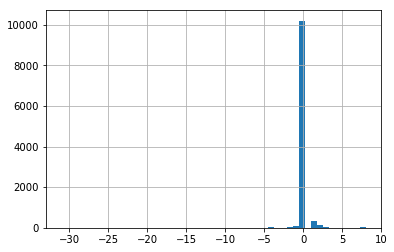

In [101]:
dots_diff.hist(bins=50)

In [59]:
dots_diff.min()

-31

In [60]:
dots_diff.max()

8

In [55]:
len(dots_diff[dots_diff == 0]) / len(dots_diff)

0.9362425355994488

In [91]:
len(dots_diff[dots_diff != 0])

694

In [76]:
dots_diff[dots_diff == dots_diff.min()]

9291   -31
dtype: int64

In [77]:
dots_diff[dots_diff == dots_diff.max()]

3844    8
3845    8
3846    8
5379    8
5380    8
5381    8
5382    8
5383    8
5384    8
5385    8
9025    8
9026    8
9027    8
9028    8
9029    8
9030    8
dtype: int64

In [17]:
def show_texts(plag_id):
    obj = train_df.loc[plag_id]
    print("Plagiat type:", obj["obfuscation"])
    print("susp/" + obj["suspicious_path"] + " : " + repr(obj["suspicious_text"]))
    print("src/"+ obj["source_path"] + " : " + repr(obj["source_text"]))

In [49]:
show_texts(14)

Plagiat type: LPR
susp/047.txt : 'Самые известные произведения Джейн Остин — это “Гордость и предубеждение” (1813 г.) и “Эмма” (1816 г.).'
src/4812682.txt : 'Ее наиболее известные книги — это “Гордость и предубеждение” (1813 г.) и “Эмма” (1816 г.).'


## Задачи, которые хорошо бы сделать

1. Разобраться, как (и с какой сложностью) работает baseline-решение.

## Вопросы, которые предстоит решить

1. Что считать границами предложения? В 6.5% случаев нельзя делить по `\n`, пример `9291`.
2. Какая метрика качества будет использоваться для итоговой оценки?

## Проблемы с обучающей выборкой

1. Не полностью выделяются куски заимствований в source, пример -- `3844` и `9026`.

---